### File: Model Optimization

##### Goals and Objectives of this file:

##### 1. Basic Model Training and Word Embedding Testing
##### 2. Data Processing => over/under sampling the classes  =>  word embeddings => Mnnb Hyperparameter Tuning
##### 3. Several Classifiers Testing => Different ML Algorithms tests => (hyper)parameter Tuning
##### 4. Testing => Testing on data never seen before => accuracy => precision => confusion matrix => roc/auc curves => learning curve

##### 5. Compare Against Sentiment Polarity Score

In [1]:
from all_libs_ml import *

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### 1. Basic Model Training and Vectorizer Testing

In [2]:
df = pd.read_csv("../smaller_dataset/yelp coffee/raw_yelp_review_data_processed.csv")

#### 1.1 Utility Functions

In [3]:
def create_train_test_split(X,y,vectorizer=False,test_size = 0.2):
    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=test_size,stratify = y,random_state = 42)
    if vectorizer:
        vectorizer = vectorizer
        x_train = vectorizer.fit_transform(x_train)
        x_test = vectorizer.transform(x_test)
    return x_train,x_test,y_train,y_test

In [4]:
def remove_stop_words(text):
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

In [5]:
def get_trained_model(classifier,x_train,x_test,y_train,y_test):
    model = classifier
    model.fit(x_train, y_train)
    return model

In [6]:
def get_model_accuracies(model,x_train,x_test,y_train,y_test):
    train_accuracy = model.score(x_train,y_train)
    val_accuracy = model.score(x_test, y_test)
    return ['{:.2f}%'.format(train_accuracy * 100),'{:.2f}%'.format(val_accuracy * 100)]

In [7]:
def print_accuracies(accuracy_scores):
    print("Training Accuracy:" + accuracy_scores[0])
    print("Testing Accuracy:" + accuracy_scores[1])

In [8]:
def adjust_xgb_labels(y_train,y_test):
    y_train_xgb = [label - 1 for label in y_train]
    y_valid_xgb = [label - 1 for label in y_test]
    
    return y_train_xgb,y_valid_xgb

In [9]:
def readjust_labels(y_train_xgb,y_test_xgb):
    y_train = [label + 1 for label in y_train_xgb]
    y_test = [label + 1 for label in y_test_xgb]
    
    return y_train,y_test

In [10]:
def show_classification_report(y_test,y_pred):
    print("Classification Report = \n ",metrics.classification_report(y_test,y_pred,zero_division=0))

In [11]:
def show_conf_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=model.classes_)
    
    disp.plot()
    plt.show()

In [12]:
def get_roc_auc(y_pred, y_test):
    # Since sklearn's roc/auc curve,
    # functions do not work with multi-class problems, the classes will have to be manually binarized
    roc_auc_dict = {}
    unique_classes = set(y_test)
    for per_class in unique_classes:
        other_classes = [chosen_class for chosen_class in unique_classes if chosen_class != per_class]
        #Binzarizing the classes
        new_y_true = [0 if this_class in other_classes else 1 for this_class in y_test]
        new_y_pred = [0 if that_class in other_classes else 1 for that_class in y_pred]
    
        roc_auc = roc_auc_score(new_y_true, new_y_pred, average = 'micro')
        roc_auc_dict[per_class] = roc_auc
        
    print("ROC/AUC for each class: \n")
    print(roc_auc_dict)
    print("\n")

In [13]:
def show_learning_curve(model, X, y,cv = 5):
    train_sizes_model, train_scores_model, valid_scores_model, *_ = learning_curve(model, X, y,cv=cv,
                    scoring='accuracy',n_jobs=-1)
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(x=train_sizes_model,y= train_scores_model.mean(axis=1), color='b')
    ax.scatter(x=train_sizes_model,y=valid_scores_model.mean(axis=1), color='r')
    ax.plot(train_sizes_model,train_scores_model.mean(axis=1), color='b')
    ax.plot(train_sizes_model,valid_scores_model.mean(axis=1), color='r')
    ax.set_xlabel('Training in blue, Testing in red')
    ax.set_ylabel('Accuracy')
    ax.set_title('Learning Curve')
    plt.show()

In [14]:
def show_metrics(model,x_train,x_test,y_train,y_test,X,y):
    show_conf_matrix(model, x_test, y_test)
    get_roc_auc(y_pred, y_test)
    show_classification_report(y_test,y_pred)
    show_learning_curve(model, X, y)

In [15]:
def translate_labels(labels):
    translated_labels = []
    for label in labels:
        if label > 3:
            translated_labels.append('Positive Sentiment')
        elif label < 3:
            translated_labels.append('Negative Sentiment')
        else:
            translated_labels.append('Neutral Sentiment')
    return translated_labels

In [16]:
def encode_sent(sentiments):
    translated_labels = sentiments
    encoded_sent = []
    for label in translated_labels:
        if label == 'Positive Sentiment':
            encoded_sent.append(1)
        elif label == 'Negative Sentiment':
            encoded_sent.append(2)
        else:
            encoded_sent.append(3)
    return encoded_sent

#### 1.2 Removing Stop Words

In [17]:
df['full_review_text'] = [remove_stop_words(text) for text in df['full_review_text']]

#### 1.3 Train-Test Split + Basic Model

In [18]:
X = df['full_review_text']
y = df['star_rating']
combined_df = pd.concat([X, y], axis=1)

In [19]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_train_test_split(X,y,TfidfVectorizer())

##### Decision Tree

In [20]:
model_DT = get_trained_model(DecisionTreeClassifier(),x_train_tfidf,x_test_tfidf,y_train,y_test)
accuracy_scores = get_model_accuracies(model_DT,x_train_tfidf,x_test_tfidf,y_train,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:100.00%
Testing Accuracy:47.43%


##### Multinomial Naive Bayes

In [21]:
model_NB = get_trained_model(MultinomialNB(),x_train_tfidf,x_test_tfidf,y_train,y_test)
accuracy_scores = get_model_accuracies(model_NB,x_train_tfidf,x_test_tfidf,y_train,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:52.73%
Testing Accuracy:50.11%


### This result can be better...

### 2. Data Processing

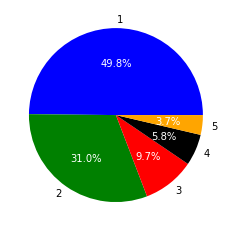

In [22]:
_, _, autotexts = plt.pie(y.value_counts(),colors = ['blue','green','red','black','orange'],labels = [1,2,3,4,5],autopct= '%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')

### This dataset will be balanced using several different techniques.

### 2.1 Data Resampling

#### Random Oversampling

In [23]:
random_oversampler = RandomOverSampler(random_state=42)
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)

In [24]:
ro_y.value_counts()

4    2757
5    2757
3    2757
2    2757
1    2757
Name: star_rating, dtype: int64

##### Decision Tree

In [25]:
model_DT = get_trained_model(DecisionTreeClassifier(),ro_x_tfidf,x_test_tfidf,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_DT,ro_x_tfidf,x_test_tfidf,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:100.00%
Testing Accuracy:45.19%


##### Multinomial Naive Bayes

In [26]:
model_NB = get_trained_model(MultinomialNB(),ro_x_tfidf,x_test_tfidf,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ro_x_tfidf,x_test_tfidf,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.98%
Testing Accuracy:53.51%


#### Random Undersampling

In [27]:
random_underSampler = RandomUnderSampler(random_state=42)
ru_x_tfidf,ru_y = random_underSampler.fit_resample(x_train_tfidf, y_train)

In [28]:
ru_y.value_counts()

1    202
2    202
3    202
4    202
5    202
Name: star_rating, dtype: int64

In [29]:
model_NB = get_trained_model(MultinomialNB(),ru_x_tfidf,x_test_tfidf,ru_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ru_x_tfidf,x_test_tfidf,ru_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:97.13%
Testing Accuracy:45.84%


#### SMOTE

In [30]:
smote_resample = SMOTE(random_state=42)
smote_x_tfidf,smote_y = smote_resample.fit_resample(x_train_tfidf, y_train)

In [31]:
smote_y.value_counts()

4    2757
5    2757
3    2757
2    2757
1    2757
Name: star_rating, dtype: int64

In [32]:
model_NB = get_trained_model(MultinomialNB(),smote_x_tfidf,x_test_tfidf,smote_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,smote_x_tfidf,x_test_tfidf,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.82%
Testing Accuracy:51.05%


### According to the accuracy results: Random Oversampling was the best method for data resampling using these basic parameters, and on TF-IDF.

### 2.2 Word Embeddings

### Word2Vec (BoW)

In [33]:
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(X)
bow_array = bow_matrix.toarray()
bow_df = pd.DataFrame(data=bow_array,columns = bow_vectorizer.vocabulary_.keys())

In [34]:
bow_df.head()

,love,loved,atmosphere,every,corner,coffee,shop,style,swing,ordered,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
(bow_df['love'] != 0).sum()

8

### TF-IDF 

In [36]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_matrix = tf_idf_vectorizer.fit_transform(X)
tf_idf_array = tf_idf_matrix.toarray()
tf_idf_df = pd.DataFrame(data=tf_idf_array,columns=tf_idf_vectorizer.vocabulary_.keys())

In [37]:
tf_idf_df.head()

,love,loved,atmosphere,every,corner,coffee,shop,style,swing,ordered,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
(tf_idf_df['love'] != 0).sum()

8

### Word2Vec vs TF-IDF (with Random Resampling)

##### Word2Vec

##### Random Oversampler

In [39]:
random_oversampler = RandomOverSampler(random_state=42)

In [40]:
x_train_bow,x_test_bow,y_train,y_test = create_train_test_split(X,y,vectorizer=bow_vectorizer)

In [41]:
ro_x_bow,ro_y = random_oversampler.fit_resample(x_train_bow, y_train)


model_NB = get_trained_model(MultinomialNB(),ro_x_bow,x_test_bow,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ro_x_bow,x_test_bow,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.69%
Testing Accuracy:56.40%


In [42]:
y_pred = model_NB.predict(x_test_bow)
print("MNNB Classification Report = \n ",metrics.classification_report(y_test,y_pred))

MNNB Classification Report = 
                precision    recall  f1-score   support

           1       0.53      0.45      0.49        51
           2       0.26      0.25      0.25        81
           3       0.29      0.37      0.32       134
           4       0.47      0.50      0.49       428
           5       0.74      0.69      0.71       689

    accuracy                           0.56      1383
   macro avg       0.46      0.45      0.45      1383
weighted avg       0.58      0.56      0.57      1383



##### TF-IDF

In [43]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_train_test_split(X,y,vectorizer=TfidfVectorizer())
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)

model_NB = get_trained_model(MultinomialNB(),ro_x_tfidf,x_test_tfidf,ro_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ro_x_tfidf,x_test_tfidf,ro_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.98%
Testing Accuracy:53.51%


### Based on the previous results: Word2Vec Outperformed TF-IDF

### Word2Vec vs TF-IDF (Optimization)

In [44]:
embed_cv = 5

In [45]:
x_train, x_test, y_train, y_test = create_train_test_split(X, y, test_size=0.2)

In [46]:
w2v_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [47]:
tfidf_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [48]:
w2v_params = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
}

In [49]:
tfidf_params = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
}

In [50]:
count_grid_search = GridSearchCV(w2v_pipeline, param_grid=w2v_params, cv=embed_cv, n_jobs=-1)
count_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [51]:
tfidf_grid_search = GridSearchCV(tfidf_pipeline, param_grid=tfidf_params, cv=embed_cv, n_jobs=-1)
tfidf_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [52]:
print("Word2Vec best parameters: ", count_grid_search.best_params_)
print("Word2Vec best score: ", count_grid_search.best_score_)

Word2Vec best parameters:  {'vect__ngram_range': (1, 1)}
Word2Vec best score:  0.5703238147511072


In [53]:
print("TF-IDF best parameters: ", tfidf_grid_search.best_params_)
print("TF-IDF best score: ", tfidf_grid_search.best_score_)

TF-IDF best parameters:  {'vect__ngram_range': (1, 1)}
TF-IDF best score:  0.5005423321261543


### Based on the previous results: Word2Vec once again outperforms TF-IDF

### Overall, for this specific dataset, and model, Word2Vec is a better choice.

In [54]:
bow_vectorizer = CountVectorizer(
    ngram_range = count_grid_search.best_params_['vect__ngram_range'],
    encoding = 'utf-8',
    binary=False)
x_train_bow,x_test_bow,y_train,y_test = create_train_test_split(X,y,vectorizer=bow_vectorizer)

### Now, the next step is to find the best resampling technique for Word2Vec

##### Random Undersampler

In [55]:
random_underSampler = RandomUnderSampler(random_state=42)

In [56]:
ru_x_bow,ru_y = random_underSampler.fit_resample(x_train_bow, y_train)

model_NB = get_trained_model(MultinomialNB(),ru_x_bow,x_test_bow,ru_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,ru_x_bow,x_test_bow,ru_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:93.56%
Testing Accuracy:42.08%


In [57]:
y_pred = model_NB.predict(x_test_bow)
print("MNNB Classification Report = \n ",metrics.classification_report(y_test,y_pred))

MNNB Classification Report = 
                precision    recall  f1-score   support

           1       0.39      0.71      0.50        51
           2       0.19      0.30      0.23        81
           3       0.18      0.43      0.25       134
           4       0.39      0.48      0.43       428
           5       0.81      0.38      0.51       689

    accuracy                           0.42      1383
   macro avg       0.39      0.46      0.39      1383
weighted avg       0.57      0.42      0.45      1383



#### SMOTE

In [58]:
smote_resample = SMOTE(random_state=42)

In [59]:
smote_x_bow,smote_y = smote_resample.fit_resample(x_train_bow, y_train)

model_NB = get_trained_model(MultinomialNB(),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(model_NB,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:71.61%
Testing Accuracy:57.92%


In [60]:
y_pred = model_NB.predict(x_test_bow)
print("MNNB Classification Report = \n ",metrics.classification_report(y_test,y_pred))

MNNB Classification Report = 
                precision    recall  f1-score   support

           1       0.68      0.33      0.45        51
           2       0.39      0.19      0.25        81
           3       0.32      0.22      0.26       134
           4       0.46      0.54      0.49       428
           5       0.70      0.74      0.72       689

    accuracy                           0.58      1383
   macro avg       0.51      0.40      0.43      1383
weighted avg       0.57      0.58      0.57      1383



### Based on these results: SMOTE and Random Oversampling were the best resampling techniques specifically for Word2Vec

### When the results are observed closely, we can see that Random Oversampling causes the model to overfit, whereas that was not the case with SMOTE. 




### it is important to take note of something when coming to a conclusion on which technique was better:

#### 1. This dataset is too small to draw a definitive conclusion on which resampling technique is best.

#### 2. The imbalance in the dataset is very severe, which works better in favour of SMOTE, as it is better at replicating synthetic labels for minority classes.

#### 3. Random Oversampling outperformed SMOTE on other metrics such as F1-Score and Precision

#### 4. Both resampling techniques are not optimal for a multi-class classification problem.

### In conclusion, there is not enough data to get a concrete answer on which resampling techinque would perform best. Therefore, SMOTE will be used as it was less likely to overfit, and the results are nearly identical to Random Oversampler, which unfortunately produced less values per class.

### Sources:
https://file.techscience.com/ueditor/files/cmc/TSP_CMC_69-1/TSP_CMC_17827/TSP_CMC_17827.pdf

https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

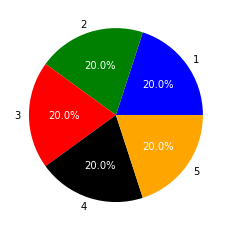

In [61]:
_, _, autotexts = plt.pie(smote_y.value_counts(),colors = ['blue','green','red','black','orange'],labels = [1,2,3,4,5],autopct= '%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')

In [62]:
smote_x_bow

<13785x16515 sparse matrix of type '<class 'numpy.int64'>'
	with 776629 stored elements in Compressed Sparse Row format>

### 2.3 Hyperparameter Tuning on the MNB model.

### First Step: Validation split

### Dataset will be split further from train-test into train-validation-test to better evaluate the model.

#### some definitons:

#### 1. x_train_val = x_bow with smote resampling and validation split

#### 2. x_val = x_test with smote resampling and validation split

#### 3. y_train_val = y_train with smote resampling and validation split

#### 4. y_val = y_test with smote resampling and validation split

In [63]:
x_train_val, x_val, y_train_val, y_val = create_train_test_split(smote_x_bow,smote_y,test_size = 0.25)

### Second Step: Hyperparameter Tuning

### 1. Grid Search

In [64]:
param_grid = {"alpha": range(1,10)}
mnnb = MultinomialNB()
grid_search = GridSearchCV(mnnb, param_grid,cv=5, verbose=2)

grid_search.fit(x_train_val, y_train_val)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=3; total time=   0.0s
[CV] END ........................................

In [65]:
print(grid_search.score(x_train_val, y_train_val))
print(grid_search.score(x_val, y_val))

0.6977171599922616
0.5938497243980273


### 2. Randomized hyperparameter optimization

In [66]:
mnnb = MultinomialNB()
random_search = RandomizedSearchCV(mnnb, param_grid, cv=5, verbose=2, n_jobs=-1, n_iter=5)
random_search.fit(x_train_val, y_train_val)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': range(1, 10)}, verbose=2)

In [67]:
random_search.score(x_val, y_val)

0.5610675950101538

### Based on these results, the alpha value is best kept at default (1.0) as there is beneficial progess that occurs after that point.

### 3. Several Classifiers Testing

### 3.1 Strong Classifiers

##### 1. Random Forest

In [68]:
rf_clf = get_trained_model(RandomForestClassifier(random_state=42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(rf_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:95.05%
Testing Accuracy:71.86%


##### 2. SVM

In [69]:
svm_clf = get_trained_model(SVC(kernel='rbf',random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(svm_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:78.97%
Testing Accuracy:62.11%


##### 3. Ensemble (Bagging) Model (KNN) 

In [70]:
ens_knn_clf = get_trained_model(BaggingClassifier(KNeighborsClassifier(),random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(ens_knn_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:63.86%
Testing Accuracy:54.57%


##### 4. Ensemble (Bagging) Model (MNNB)

In [71]:
ens_mnnb_clf = get_trained_model(BaggingClassifier(MultinomialNB(),random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(ens_mnnb_clf,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:67.86%
Testing Accuracy:58.31%


##### 5. Gradient Boosting  (Adaboost) Model (MNNB)

In [72]:
ens_mnnb_clf_ada = get_trained_model(AdaBoostClassifier(MultinomialNB(),random_state = 42),x_train_val,x_val,y_train_val,y_val)
accuracy_scores = get_model_accuracies(ens_mnnb_clf_ada,x_train_val,x_val,y_train_val,y_val)
print_accuracies(accuracy_scores)

Training Accuracy:55.48%
Testing Accuracy:52.80%


##### 6. Gradient Boosting (XGBoost) Model

#### Some Label adjustments specifically for XGBoost

In [73]:
y_train_xgb,y_val_xgb = adjust_xgb_labels(y_train_val,y_val)

#### Model Training

In [74]:
xgb_model = get_trained_model(XGBClassifier(random_state = 42),x_train_val,x_val,y_train_xgb,y_val_xgb)
accuracy_scores = get_model_accuracies(xgb_model,x_train_val,x_val,y_train_xgb,y_val_xgb)
print_accuracies(accuracy_scores)

Training Accuracy:96.32%
Testing Accuracy:85.47%


### Based on these results, These Were the Top 3 Classifiers without Parameter Tuning:

#### 3. SVM

#### 2. Random Forest

#### 1. XGBoost

### 3.2 Parameter Tuning

In [75]:
num_cv = 5
baseline = "baseline.pickle"
optimized = "optimized_params.pickle"

In [76]:
params = {'learning_rate': [0.1, 0.2,0.3],
              'max_depth': [5, 7, 9],
              'min_child_weight': [1, 3, 5],
              'subsample': [0.5, 0.7, 1.0],
              'colsample_bytree': [0.5, 0.7, 1.0],
              'gamma':[1,2,3],
              'alpha':[0.001,0.01,0.1],
         }

In [77]:
if not os.path.exists('../pickle_files'):
    os.mkdir('../pickle_files')

In [78]:
if pickle.load(open("../pickle_files/" + baseline, "rb")):
    print("Found Pickle File!")
else:
    xgb_clf = XGBClassifier(random_state = 42)
    grid_search = GridSearchCV(xgb_clf, xgb_params,cv=num_cv,n_jobs = -1, verbose=1)
    grid_search.fit(x_train_val, y_train_xgb)

    pickle_out = open("../pickle_files/" + baseline,'wb')
    pickle.dump(grid_search.best_params_,pickle_out)
    pickle_out.close()

Found Pickle File!


In [79]:
if pickle.load(open("../pickle_files/" + optimized, "rb")):
    print("Found Pickle File!")
else:
    xgb_clf = XGBClassifier(random_state = 42)
    grid_search = GridSearchCV(xgb_clf, xgb_params,cv=num_cv,n_jobs = -1, verbose=1)
    grid_search.fit(x_train_val, y_train_xgb)

    pickle_out = open("../pickle_files/" + optimized,'wb')
    pickle.dump(grid_search.best_params_,pickle_out)
    pickle_out.close()

Found Pickle File!


In [80]:
baseline_params = pickle.load(open("../pickle_files/" + baseline, "rb"))
print(baseline_params)

print('\n')

optimized_params = pickle.load(open("../pickle_files/" + optimized,"rb"))
print(optimized_params)

{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 1.0}


{'alpha': 0.001, 'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 1.0}


{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 1.0}

In [81]:
xgb_model_new = get_trained_model(XGBClassifier(
    colsample_bytree = 0.7,
    learning_rate = 0.3,
    max_depth = 9,
    min_child_weight = 1,
    subsample = 1.0,
    random_state = 42),
        x_train_val,x_val,y_train_xgb,y_val_xgb)
accuracy_scores = get_model_accuracies(xgb_model_new,x_train_val,x_val,y_train_xgb,y_val_xgb)
print_accuracies(accuracy_scores)

Training Accuracy:99.01%
Testing Accuracy:85.52%


In [82]:
xgb_model_optimized = get_trained_model(XGBClassifier(
    alpha = 0.01,
    colsample_bytree = 0.7,
    gamma = 1,
    learning_rate = 0.2,
    max_depth = 9,
    min_child_weight = 1,
    subsample = 1.0,
    random_state = 42),
        x_train_val,x_val,y_train_xgb,y_val_xgb)
accuracy_scores = get_model_accuracies(xgb_model_optimized,x_train_val,x_val,y_train_xgb,y_val_xgb)
print_accuracies(accuracy_scores)

Training Accuracy:96.79%
Testing Accuracy:85.32%


### Based on these results: XGBoost caps out around the baseline accuracy.

### 4. Testing

In [83]:
rf_clf = get_trained_model(RandomForestClassifier(random_state=42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(rf_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:94.93%
Testing Accuracy:51.63%


In [84]:
svm_clf = get_trained_model(SVC(kernel='rbf',random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(svm_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:79.71%
Testing Accuracy:56.69%


In [85]:
ens_knn_clf = get_trained_model(BaggingClassifier(KNeighborsClassifier(),random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(ens_knn_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:65.23%
Testing Accuracy:16.63%


In [86]:
ens_mnnb_clf = get_trained_model(BaggingClassifier(MultinomialNB(),random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(ens_mnnb_clf,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:68.89%
Testing Accuracy:58.28%


In [87]:
ens_mnnb_clf_ada = get_trained_model(AdaBoostClassifier(MultinomialNB(),random_state = 42),smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(ens_mnnb_clf_ada,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:54.67%
Testing Accuracy:49.89%


In [88]:
smote_y,y_test = adjust_xgb_labels(smote_y,y_test)

In [89]:
xgb_model_new = get_trained_model(XGBClassifier(
    colsample_bytree = 0.7,
    learning_rate = 0.3,
    max_depth = 9,
    min_child_weight = 1,
    subsample = 1.0,
    random_state = 42),
        smote_x_bow,x_test_bow,smote_y,y_test)
accuracy_scores = get_model_accuracies(xgb_model_new,smote_x_bow,x_test_bow,smote_y,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:98.35%
Testing Accuracy:56.91%


### Top 3 Classifiers after testing:

#### 3. SVM

#### 2. XGBoost

#### 1. Ensemble MNNB (Bagging)

### 4.1 Top 3 Classifiers' Metrics Showcases

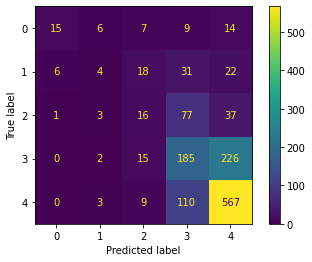

ROC/AUC for each class: 

{0: 0.2991079314608726, 1: 0.31689139216020934, 2: 0.3019788965500758, 3: 0.4004575035474873, 4: 0.5928715132401718}


Classification Report = 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.16      0.05      0.08        81
           2       0.16      0.04      0.07       134
           3       0.20      0.04      0.07       428
           4       0.33      0.24      0.28       689
           5       0.00      0.00      0.00         0

    accuracy                           0.14      1383
   macro avg       0.14      0.06      0.08      1383
weighted avg       0.25      0.14      0.17      1383



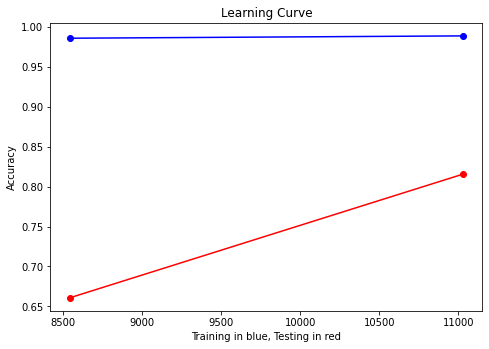

In [90]:
show_metrics(xgb_model_new,smote_x_bow,x_test_bow,smote_y,y_test,smote_x_bow,smote_y)

In [91]:
smote_y,y_test = readjust_labels(smote_y,y_test)

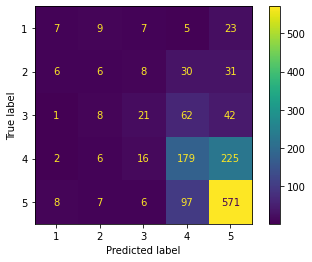

ROC/AUC for each class: 

{1: 0.6636636636636636, 2: 0.5837600273084144, 3: 0.582988779082968, 4: 0.6257596516122719, 5: 0.715202461070005}


Classification Report = 
                precision    recall  f1-score   support

           1       0.68      0.33      0.45        51
           2       0.39      0.19      0.25        81
           3       0.32      0.22      0.26       134
           4       0.46      0.54      0.49       428
           5       0.70      0.74      0.72       689

    accuracy                           0.58      1383
   macro avg       0.51      0.40      0.43      1383
weighted avg       0.57      0.58      0.57      1383



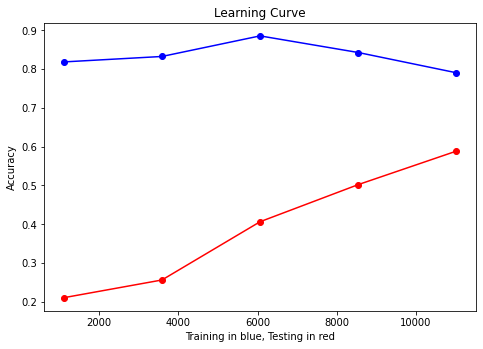

In [92]:
show_metrics(svm_clf,smote_x_bow,x_test_bow,smote_y,y_test,smote_x_bow,smote_y)

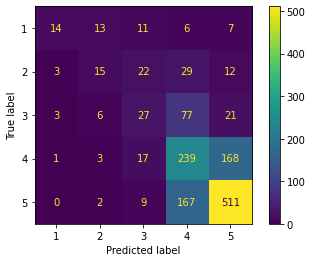

ROC/AUC for each class: 

{1: 0.6636636636636636, 2: 0.5837600273084144, 3: 0.582988779082968, 4: 0.6257596516122719, 5: 0.715202461070005}


Classification Report = 
                precision    recall  f1-score   support

           1       0.68      0.33      0.45        51
           2       0.39      0.19      0.25        81
           3       0.32      0.22      0.26       134
           4       0.46      0.54      0.49       428
           5       0.70      0.74      0.72       689

    accuracy                           0.58      1383
   macro avg       0.51      0.40      0.43      1383
weighted avg       0.57      0.58      0.57      1383



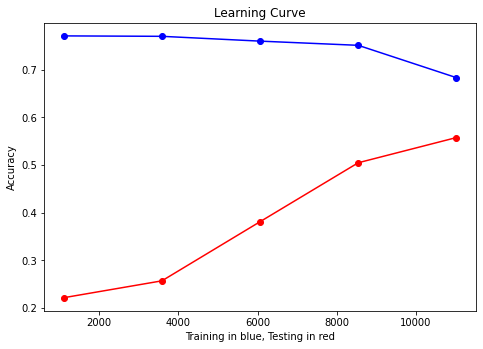

In [93]:
show_metrics(ens_mnnb_clf,smote_x_bow,x_test_bow,smote_y,y_test,smote_x_bow,smote_y)

# Very Important: Takeaways from the previous experiments:

#### 1. Dataset is too small to generalize off of.

#### 2. Sklearn's Word Embeddings produce sparse matrices that are too inefficient, and produce lacking results.

#### 3. Dataset requires a larger vocabulary.

#### 4. Machine Learning models are not sufficient to solve this problem.

### 5. Comparison with Sentiment Polarity

#### Last thing to do is to compare the results of these models with the sentiment polarity score.

In [94]:
star_rating_translated = translate_labels(df['star_rating'])
y_true = encode_sent(star_rating_translated)
y_pred = encode_sent(df['str_sent'])

In [95]:
len(y_true)

6915

In [96]:
len(y_pred)

6915

In [97]:
sent_polarity_score = accuracy_score(y_true,y_pred)

In [98]:
sent_polarity_score

0.8250180766449747

### Based on these results: Sentiment Polarity was more accurate than tested models, but less accurate against validated models

### Note: Sentiment Polarity was only trained on three labels rather than five, which is an unfair comparison. I decided to test a few several models with only three labels to verify my results.

In [99]:
x_train,x_test,y_train,y_test = create_train_test_split(X,y_true,vectorizer=bow_vectorizer)

In [100]:
# smote_resample = SMOTE(random_state=42)
# smote_features,smote_labels = smote_resample.fit_resample(x_train, y_train)

### 1. SVM

In [101]:
svm_clf = get_trained_model(SVC(kernel='rbf',random_state = 42),x_train,x_test,y_train,y_test)
accuracy_scores = get_model_accuracies(svm_clf,x_train,x_test,y_train,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:90.60%
Testing Accuracy:81.85%


### 2. Ensemble Naive Bayes (Bagging)

In [102]:
ens_mnnb_clf = get_trained_model(BaggingClassifier(MultinomialNB(),random_state = 42),x_train,x_test,y_train,y_test)
accuracy_scores = get_model_accuracies(ens_mnnb_clf,x_train,x_test,y_train,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:89.30%
Testing Accuracy:82.94%


### 3. XGboost

In [103]:
y_train,y_test = adjust_xgb_labels(y_train,y_test)

In [104]:
xgb_model_new = get_trained_model(XGBClassifier(
    colsample_bytree = 0.7,
    learning_rate = 0.3,
    max_depth = 9,
    min_child_weight = 1,
    subsample = 1.0,
    random_state = 42),
        x_train,x_test,y_train,y_test)
accuracy_scores = get_model_accuracies(xgb_model_new,x_train,x_test,y_train,y_test)
print_accuracies(accuracy_scores)

Training Accuracy:99.46%
Testing Accuracy:83.59%


### As a result of reducing the labels, the three models were able to achieve very similar, and even higher scores than the sentiment polarity scores.

### Final Notes:

#### 1. Sklearn's word embeddings were used instead of gensim as gensim was tested before, and it was proven to be difficult to work with. Also, in the playground file, you can find an example of gensim code, and from there you can see that gensim was not very practical to work with.

#### 2. Other word embeddings such as GloVe and FastText were not tested in this file as glove embeddings work better with more sophisticated models and neural networks such as the ones that will be tested using the bigger dataset, and FastText will be covered in future files, where word embeddings will play a bigger role, and more data will be available to make a more informed decision about which word embedding works best.

#### 3. The Utility Functions in this file will be moved to a python script, and utilized further in the upcoming files.